In [ ]:
# download main resources for this project
# !gdown --id 1Qtb3CtZZu00EaQrlbS_8BAhZjbvd5HmJ

In [ ]:
# unzip resources folder
# !unzip -qq "/content/drive/MyDrive/Colab Notebooks/SuperAI_Hackathon/Hackathon_week2_NLP/Resources_bestCORPUS_LST20_IMDB.zip" -d "/content"

### create_char_dictionary.ipynb

In [ ]:
from glob import glob
import os

In [ ]:
# get all file path in corpus
# PATH_MAIN = '/content/content/drive/MyDrive/Colab Notebooks/SuperAI_Hackathon/Hackathon_week2_NLP/Resources'
PATH_MAIN = '/content/Resources'

files = glob(os.path.join(PATH_MAIN, 'BEST_I_CORPUS/TrainingSet/*/*'))
# files = glob('../*.txt')
print('Number of files: ', len(files))

Number of files:  5522


In [ ]:
# get character set
def get_char(text):
    return set(text)

In [ ]:
# Create character set from all files

# cnt = 0
CHARSET = set()
for fpath in files:
    with open(fpath, mode='r', encoding="utf8") as file:
        text = file.read()  # read file
        CHARSET = CHARSET.union(get_char(text))
        # cnt = cnt + len(text)

CHARSET = sorted(CHARSET)  # sorting char
print('Number of unique char: ', len(CHARSET))
# print('Number of character: ', cnt)

Number of unique char:  197


In [ ]:
# CHARSET

In [ ]:
# Create char index dictionary and append <pad>, <unk>
# <pad>: for blank char
# <unk>: for unknow char

CHAR_INDICES = dict((c, i) for i, c in enumerate(CHARSET))
CHAR_INDICES['<pad>'] = len(CHAR_INDICES)
CHAR_INDICES['<unk>'] = len(CHAR_INDICES)

# INDICES_CHAR = dict((i, c) for i, c in enumerate(CHAR_INDICES))

print('Number of unique char: ', len(CHAR_INDICES))

Number of unique char:  199


In [ ]:
# save to json file
# PATH_MAIN = '/content/content/drive/MyDrive/Colab Notebooks/SuperAI_Hackathon/Hackathon_week2_NLP/Resources'
import json

def to_json(fname, data_dict):
    json_data = json.dumps(data_dict)
    with open(fname,'w') as file:
        file.write(json_data)
        
# save dictionary
to_json(os.path.join(PATH_MAIN,'models/CHAR_INDICES_199.json'), CHAR_INDICES)
# to_json('../models/INDICES_CHAR.json', INDICES_CHAR)

# thai_word_segmentation.ipynb

### Load Dataset
Download dataset from https://www.nectec.or.th/corpus/index.php?league=pm

In [ ]:
from glob import glob
import numpy as np

List file path

In [ ]:
# PATH_MAIN = '/content/content/drive/MyDrive/Colab Notebooks/SuperAI_Hackathon/Hackathon_week2_NLP/Resources'
files = glob(os.path.join(PATH_MAIN,'BEST_I_CORPUS/TrainingSet/*/*'))
print('Number of files: ', len(files))

Number of files:  5522


Loading char indices dictionary in to CHAR_INDICES variable

In [ ]:
import json

def read_json(fname, key_int=False):
    with open(fname, 'r') as file:
        data = file.read()
        json_data = json.loads(data)
        
        if not key_int:
            return json_data
        
        json_data = {int(key): value for key, value in json_data.items()}
        return json_data

In [ ]:
# PATH_MAIN = '/content/content/drive/MyDrive/Colab Notebooks/SuperAI_Hackathon/Hackathon_week2_NLP/Resources'
CHAR_INDICES = read_json(os.path.join(PATH_MAIN, 'models/CHAR_INDICES_199.json'), key_int=False)

### Preprocessing
1. Read text from each file
2. Remove inappropriate word/char
3. Create dataset (sequence data for LSTM)
4. Data ecoding (one-hot encoding)

In [ ]:
def replace(text, wordlist):
    for new_word, list_ in wordlist.items():
        for old_word in list_:
            text = text.replace(old_word.lower(), new_word)
    return text

    
def preprocessing(text, wordlist):
    text = text.lower()  # to lower-case
    text = replace(text, wordlist)
    return text


def create_dataset(text, look_back=20):
    X, y = [], []
    text = '|' + text
    data = [CHAR_INDICES['<pad>']] * look_back
    for i in range(1, len(text)):
        current_char = text[i]
        before_char = text[i-1]

        if current_char == '|':
            continue

        data = data[1:] + [CHAR_INDICES[current_char]]  # X data
        target = 1 if before_char == '|' else 0  # y data

        X.append(data)
        y.append(target)
    y[-1] = 1  # end text is '|'
    return X, y


def encode_data(X, y):
    sequence_len = len(X[0])
    encode_X = np.zeros((len(X), sequence_len, len(CHAR_INDICES)), dtype=np.bool)
    encode_y = np.zeros((len(y), 2), dtype=np.bool)
    for i, (data, target) in enumerate(zip(X, y)):
        for t, char in enumerate(data):
            encode_X[i, t, char] = 1
        encode_y[i, target] = 1
        
    return encode_X, encode_y


def read_text(file):
    return open(file, encoding='utf-8').read()

### Train-Test-Validate
Random file name for train, test and validate

In [ ]:
import random

def train_test_split(files, test_size=0.3):
    random.seed(4)
    random.shuffle(files)
    test_size = int(len(files) * test_size)
    train, test = files[:-test_size], files[-test_size:]
    return train, test

In [ ]:
file_train, file_test = train_test_split(files, test_size=0.05)
file_train, file_validate = train_test_split(file_train, test_size=0.05)

In [ ]:
print('Number of file for traing:', len(file_train))
print('Number of file for validate:',len(file_validate))
print('Number of file for test:', len(file_test))

Number of file for traing: 4984
Number of file for validate: 262
Number of file for test: 276


### Create Model

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, Bidirectional
from keras.utils.vis_utils import plot_model
from IPython.display import Image
import copy

from keras.layers import Embedding, LSTM, TimeDistributed, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau,CSVLogger

Count number of each dataset (train, test ,validate)

In [ ]:
wordlist = {
    '': ['<AB>', '</AB>', '<NE>', '</NE>', '\n'],
}

wordlist2 = copy.deepcopy(wordlist)
wordlist2[''].append('|')

nb_data_train = sum(len(preprocessing(read_text(file), wordlist2)) for file in file_train)
nb_data_validate = sum(len(preprocessing(read_text(file), wordlist2)) for file in file_validate)
nb_data_test = sum(len(preprocessing(read_text(file), wordlist2)) for file in file_test)

print('Number of data on train set: ', nb_data_train)
print('Number of data on validate set: ', nb_data_validate)
print('Number of data on test set: ', nb_data_test)
print('Number of all data: ', sum([nb_data_train, nb_data_validate, nb_data_test]))

Number of data on train set:  29906591
Number of data on validate set:  1819046
Number of data on test set:  1548430
Number of all data:  33274067


Config var

In [ ]:
LOOK_BACK = 20
batch_size = 4096
steps_per_epoch = int(nb_data_train / batch_size)
validation_steps = int(nb_data_train / (batch_size * 10))

Build model and plot model

In [ ]:
# optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

# def define_model(input_shape):
#     model = Sequential()
#     model.add(
#         Bidirectional(LSTM(input_shape[1]//2, input_shape=input_shape,
#                            return_sequences=False),
#                       merge_mode='sum',
#                       weights=None,
#                       input_shape=input_shape))
    

#     model.add(Dense(input_shape[1]//4, activation='linear'))

      
#     model.add(Dense(2, activation='softmax'))
#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])  # compile
    
#     print('Total params: ', model.count_params())
#     return model

In [ ]:
# # BiLSTM model
# x = Bidirectional(LSTM(max_len, return_sequences=True), name="bilstm_1")(embedding_layer)
# x = Bidirectional(LSTM(max_len, return_sequences=False), name="bilstm_2")(x)
# x = Dense(300, activation="relu")(x)
# x = Dense(200, activation="relu")(x)
# x = Dense(relu_size, activation="relu", name="relu_layer")(x)
# output_layer = Dense(50, activation="softmax")(x)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

def define_model(input_shape):
    model = Sequential()
    model.add(
        Bidirectional(LSTM(input_shape[1]//2, input_shape=input_shape,
                           return_sequences=True),
                      name="BiLSTM_1",
                      merge_mode='sum',
                      weights=None,
                      input_shape=input_shape))
    
    model.add(Dropout(0.3, name="Dropout_1"))

    model.add(Bidirectional(LSTM(input_shape[1]//2, return_sequences = False),  
                            name="BiLSTM_2"))
    
    model.add(Dropout(0.3, name="Dropout_2"))
        
    model.add(Dense(input_shape[1]//4, activation='linear', name='Dense_1'))

    model.add(Dropout(0.3, name="Dropout_3"))

      
    model.add(Dense(2, activation='softmax', name='Dense_2'))
  
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])  # compile
    
    print('Total params: ', model.count_params())
    return model

In [ ]:
# optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

# def define_model(input_shape):
#     model = Sequential()
#     #Embedding layer
#     model.add(Embedding(input_shape[1], 5, input_length=input_shape[0]))

#     # LSTM Layer #1
#     lstm = LSTM(256, return_sequences=True, unroll=True, dropout=0.1, recurrent_dropout=0.1)

#     model.add(Bidirectional(lstm))
#     model.add(Dropout(0.1))
    
#     # LSTM Layer #2
#     lstm = LSTM(256, return_sequences=True, unroll=True, dropout=0.1, recurrent_dropout=0.1)
    
#     model.add(Bidirectional(lstm))
#     model.add(Dropout(0.1))

#     # LSTM Layer #3
#     lstm = LSTM(128, return_sequences=False, unroll=True, dropout=0.25, recurrent_dropout=0.25)

#     model.add(Bidirectional(lstm))
#     model.add(Dropout(0.25))

#     # RNN
#     model.add(TimeDistributed(Dense(2, activation="softmax"),  
#                               input_shape=(20, 128)))    

#     # Compile
#     model.compile(loss="categorical_crossentropy", optimizer=optimizer,  
#                   metrics=["categorical_accuracy"])
    
#     print('Total params: ', model.count_params())
#     return model

Total params:  404267


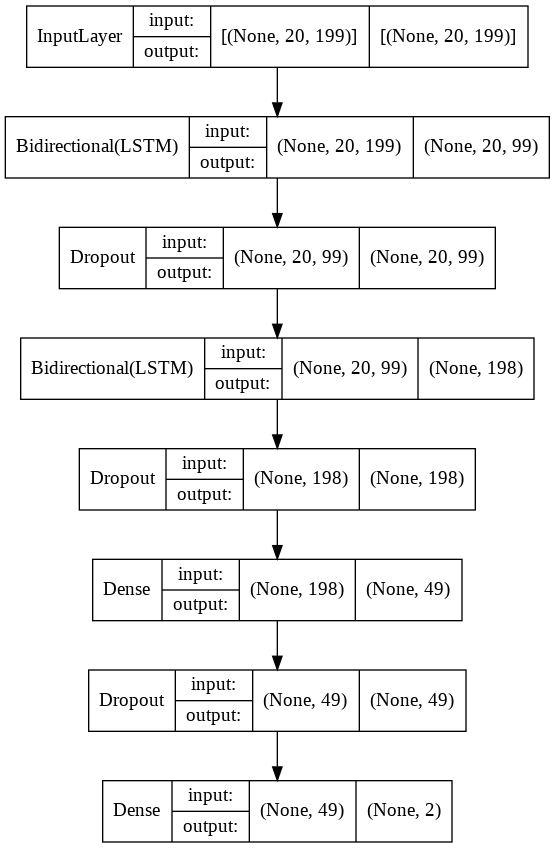

In [ ]:
input_shape = (LOOK_BACK, len(CHAR_INDICES))
model = define_model(input_shape)  # define model

# plot model
image_name = '/content/model.png'
plot_model(model, image_name, show_shapes=True, show_layer_names=False)
display(Image(filename=image_name))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 BiLSTM_1 (Bidirectional)    (None, 20, 99)            236808    
                                                                 
 Dropout_1 (Dropout)         (None, 20, 99)            0         
                                                                 
 BiLSTM_2 (Bidirectional)    (None, 198)               157608    
                                                                 
 Dropout_2 (Dropout)         (None, 198)               0         
                                                                 
 Dense_1 (Dense)             (None, 49)                9751      
                                                                 
 Dropout_3 (Dropout)         (None, 49)                0         
                                                                 
 Dense_2 (Dense)             (None, 2)                

Create *GENERATOR* for training **LARGE dataset**

In [ ]:
import math

def generator(files, wordlist, batch_size=1024, look_back=20, mode='Training', display_=False):
    while True:
        copy_files = files.copy()
        random.shuffle(copy_files)

        for file in copy_files:
            if display_ is True:
                print(f'\n{mode} file: ' + file)

            text = read_text(file)
            text = preprocessing(text, wordlist)
            X_data, y_data = create_dataset(text, look_back)
            X_data, y_data = encode_data(X_data, y_data)

            samples_per_epoch  = len(X_data)
            number_of_batches = int(math.ceil(samples_per_epoch / batch_size))

            for counter in range(number_of_batches):
                X_batch = np.array(X_data[batch_size*counter:batch_size*(counter+1)])
                y_batch = np.array(y_data[batch_size*counter:batch_size*(counter+1)])
                yield X_batch, y_batch

In [ ]:
# Generators
training_generator = generator(file_train, 
                               wordlist, 
                               batch_size, 
                               look_back=LOOK_BACK, 
                               mode='Training')

validation_generator = generator(file_validate, 
                                 wordlist, 
                                 batch_size, 
                                 look_back=LOOK_BACK, 
                                 mode='Validation')

print('steps per epoch', steps_per_epoch)
print('validation steps', validation_steps)

steps per epoch 7301
validation steps 730


### Callbacks  
Callback config  
- checkpoint
- step decay

In [ ]:
PATH_main = '/content/drive/MyDrive/Hackathon_NLP/Model'

# callbacks
# path_to_save_model = os.path.join(PATH_main,  
#                                   "models_IMDB_bs12288_BiLSTM_lb10/weights-improvement-{epoch:03d}-{val_accuracy:.3f}_extension.hdf5")

path_to_save_model = os.path.join(PATH_main,  
                                  "models_IMDB_bs4096_2BiLSTM/weights-improvement_extension.hdf5")

ckpt_saver = ModelCheckpoint(
    path_to_save_model,  
    monitor="val_accuracy",  
    mode="max",  
    save_best_only=True,  
    save_freq='epoch',  
    verbose=1
)

# EarlyStopping
early_stopping = EarlyStopping(monitor="val_accuracy",  
                               patience=5, verbose=1)

# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=2, min_lr=1e-8)

# CSV Log
csv_logger = CSVLogger('/content/drive/MyDrive/Hackathon_NLP/Model/models_IMDB_bs4096_2BiLSTM/training.log', separator=',', append=False)

In [ ]:
# from matplotlib import pyplot as plt

In [ ]:
# checkpoint
# Note: Path for saving model should be changed to your personal drive

# PATH_MAIN = '/content/drive/MyDrive/Hackathon_NLP/Model'
# filepath=os.path.join(PATH_MAIN, "models_1024/weights-improvement-{epoch:03d}-{val_accuracy:.3f}_extension.hdf5")
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
# # step decay

# def step_decay(epoch):
#     initial_lrate = 0.001
#     min_lrat = 0.0001
#     drop_per_epoch = (initial_lrate - min_lrat) / NB_EPOCH
#     lrate = initial_lrate - (drop_per_epoch * epoch)
#     return lrate

# NB_EPOCH = 50
# lrate = LearningRateScheduler(step_decay)

# plt.plot([step_decay(i) for i in range(NB_EPOCH)]);
# plt.savefig('/content/step-decay.png')

In [ ]:
# callbacks_list = [checkpoint, lrate]
callbacks_list = [ckpt_saver, early_stopping, reduce_lr, csv_logger]

In [ ]:
import datetime
def textout(input_string):
    print(input_string)

In [ ]:
textout("START TRAINING")
start_time = datetime.datetime.now().replace(microsecond=0)
textout("Time ==> " + str(start_time.strftime("%Y-%m-%d %H:%M:%S")))

# training

history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=100,
                    verbose=1,
                    callbacks=callbacks_list)

finish_time = datetime.datetime.now().replace(microsecond=0)
textout("END")
textout("Time ==> " + str(finish_time.strftime("%Y-%m-%d %H:%M:%S")) )
textout("TIME USED => " + str(finish_time - start_time))

START TRAINING
Time ==> 2022-02-21 14:20:40
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for 

7301/7301 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.9439
Epoch 1: val_accuracy improved from -inf to 0.96261, saving model to /content/drive/MyDrive/Hackathon_NLP/Model/models_IMDB_bs4096_2BiLSTM/weights-improvement_extension.hdf5
7301/7301 [==============================] - 557s 75ms/step - loss: 0.1413 - accuracy: 0.9439 - val_loss: 0.0973 - val_accuracy: 0.9626 - lr: 0.0010
Epoch 2/100
7301/7301 [==============================] - ETA: 0s - loss: 0.0947 - accuracy: 0.9643
Epoch 2: val_accuracy improved from 0.96261 to 0.97021, saving model to /content/drive/MyDrive/Hackathon_NLP/Model/models_IMDB_bs4096_2BiLSTM/weights-improvement_extension.hdf5
7301/7301 [==============================] - 548s 75ms/step - loss: 0.0947 - accuracy: 0.9643 - val_loss: 0.0787 - val_accuracy: 0.9702 - lr: 0.0010
Epoch 3/100
7299/7301 [============================>.] - ETA: 0s - loss: 0.0830 - accuracy: 0.9687
Epoch 3: val_accuracy improved from 0.97021 to 0.97367, saving mod

Model history plot
- loss
- acc

In [ ]:
import matplotlib.pyplot as plt

history key:  ['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr']


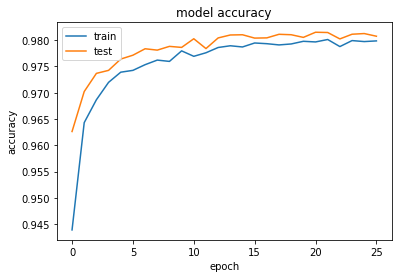

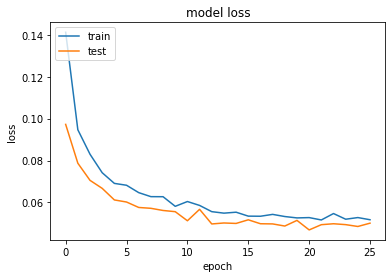

In [ ]:
plot_pathsave = '/content/drive/MyDrive/Hackathon_NLP/Model/models_IMDB_bs4096_2BiLSTM/history-{}.png'

# keys of history
print('history key: ', list(history.history.keys()))

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(plot_pathsave.format('acc'))  # save to image
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(plot_pathsave.format('loss'))  # save to image
plt.show()

### Evaluate
Evaluate each file on test and calculate mean score.  
Loading best model (best **acc score** on validate set).

Metrics
- precision
- recall
- fscore

Using sklearn
- precision_recall_fscore_support: average='binary'
- accuracy_score

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from keras.models import load_model

In [ ]:
# PATH_MAIN = '/content/content/drive/MyDrive/Colab Notebooks/SuperAI_Hackathon/Hackathon_week2_NLP/Resources'
# PATH_MAIN = '/content/drive/MyDrive/Hackathon_NLP/Model'
# best_model_checkpoint = sorted(glob(os.path.join(PATH_MAIN, 'models_1024/*')))[-1] # change path for your model
# PATH_model = "/content/drive/MyDrive/font_Models/InceptionV3_all/model_style_inception_all"
best_model = tf.keras.models.load_model('/content/drive/MyDrive/Hackathon_NLP/Model/models_IMDB_bs4096_2BiLSTM/weights-improvement_extension.hdf5')

# print(best_model_checkpoint)

# best_model = load_model(best_model_checkpoint)  # load Model

In [ ]:
def pred_preprocessing(text, sequence_len=20):
    # create dataset
    X = []
    data = [CHAR_INDICES['<pad>']] * sequence_len
    for char in text:
        char = char if char in CHAR_INDICES else '<unk>'  # check char in dictionary
        data = data[1:] + [CHAR_INDICES[char]]  # X data
        X.append(data)
        
    # data encoding
    encode_X = np.zeros((len(X), sequence_len, len(CHAR_INDICES)), dtype=np.bool)
    for i, data in enumerate(X):
        for t, char in enumerate(data):
            encode_X[i, t, char] = 1
    return encode_X


def predict(model, text_encode):
    preds = model.predict(text_encode)
    class_ = [np.argmax(pred) for pred in preds]
    return class_

In [ ]:
LOOK_BACK = 20

avg = {
    'precision': [],
    'recall': [],
    'fscore': [],
    'acc': []
}

for i, fpath in enumerate(file_test):
    print(f'{i+1}/{len(file_test)}: ', fpath)
    
    _, y_true = create_dataset(preprocessing(read_text(fpath), wordlist), look_back=LOOK_BACK)
    y_pred = predict(best_model, pred_preprocessing(preprocessing(read_text(fpath), wordlist2)))
    
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    acc = accuracy_score(y_true, y_pred)
    
    avg['precision'].append(precision)
    avg['recall'].append(recall)
    avg['fscore'].append(fscore)
    avg['acc'].append(acc)
    
    print('precision: ', round(precision, 3))
    print('recall: ', round(recall, 3))
    print('fscore: ', round(fscore, 3))
    print('accuracy: ' , round(acc, 3))
    print('Number of data: ', len(y_pred))
    print('-' * 50)

1/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10372_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.975
recall:  0.909
fscore:  0.941
accuracy:  0.963
Number of data:  908
--------------------------------------------------
2/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01539_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.96
recall:  0.971
fscore:  0.965
accuracy:  0.98
Number of data:  2195
--------------------------------------------------
3/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11152_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.966
recall:  0.972
fscore:  0.969
accuracy:  0.984
Number of data:  2779
--------------------------------------------------
4/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00528_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.954
recall:  0.975
fscore:  0.964
accuracy:  0.981
Number of data:  6681
--------------------------------------------------
5/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00306_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.968
recall:  0.963
fscore:  0.965
accuracy:  0.982
Number of data:  2106
--------------------------------------------------
6/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T12440_prep.txt
precision:  0.992
recall:  0.988
fscore:  0.99
accuracy:  0.995
Number of data:  935
--------------------------------------------------
7/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_test_prep/T12598_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.962
recall:  0.95
fscore:  0.956
accuracy:  0.977
Number of data:  913
--------------------------------------------------
8/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11639_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.978
recall:  0.983
fscore:  0.981
accuracy:  0.987
Number of data:  2238
--------------------------------------------------
9/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11781_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.962
recall:  0.968
fscore:  0.965
accuracy:  0.978
Number of data:  2780
--------------------------------------------------
10/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T12858_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.968
recall:  0.99
fscore:  0.979
accuracy:  0.989
Number of data:  1539
--------------------------------------------------
11/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/other/person_names_female.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.618
recall:  0.545
fscore:  0.579
accuracy:  0.889
Number of data:  36301
--------------------------------------------------
12/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00361_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.931
recall:  0.987
fscore:  0.958
accuracy:  0.978
Number of data:  1529
--------------------------------------------------
13/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11360_prep.txt
precision:  0.985
recall:  0.985
fscore:  0.985
accuracy:  0.991
Number of data:  906
--------------------------------------------------
14/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10701_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.949
recall:  0.965
fscore:  0.957
accuracy:  0.974
Number of data:  772
--------------------------------------------------
15/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10106_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.968
recall:  0.977
fscore:  0.973
accuracy:  0.987
Number of data:  1903
--------------------------------------------------
16/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01535_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.961
recall:  0.97
fscore:  0.966
accuracy:  0.982
Number of data:  10662
--------------------------------------------------
17/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11340_prep.txt
precision:  0.978
recall:  0.978
fscore:  0.978
accuracy:  0.989
Number of data:  698
--------------------------------------------------
18/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/novel/novel_00047.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.963
recall:  0.967
fscore:  0.965
accuracy:  0.979
Number of data:  34920
--------------------------------------------------
19/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T10854_prep.txt
precision:  0.991
recall:  0.926
fscore:  0.958
accuracy:  0.981
Number of data:  1040
--------------------------------------------------
20/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11901_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.971
recall:  0.935
fscore:  0.953
accuracy:  0.979
Number of data:  486
--------------------------------------------------
21/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T12860_prep.txt
precision:  0.977
recall:  0.99
fscore:  0.984
accuracy:  0.991
Number of data:  1145
--------------------------------------------------
22/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11439_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.954
recall:  0.978
fscore:  0.966
accuracy:  0.984
Number of data:  1206
--------------------------------------------------
23/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00641_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.971
recall:  0.964
fscore:  0.968
accuracy:  0.982
Number of data:  4593
--------------------------------------------------
24/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/article/article_00056.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.947
recall:  0.964
fscore:  0.955
accuracy:  0.975
Number of data:  43700
--------------------------------------------------
25/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11233_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.972
recall:  0.981
fscore:  0.977
accuracy:  0.989
Number of data:  3638
--------------------------------------------------
26/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/news/news_00094.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.94
recall:  0.952
fscore:  0.946
accuracy:  0.971
Number of data:  64490
--------------------------------------------------
27/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00976_prep.txt
precision:  0.981
recall:  0.996
fscore:  0.989
accuracy:  0.994
Number of data:  1084
--------------------------------------------------
28/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10671_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.966
recall:  0.981
fscore:  0.973
accuracy:  0.984
Number of data:  863
--------------------------------------------------
29/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T12822_prep.txt
precision:  0.96
recall:  0.984
fscore:  0.972
accuracy:  0.986
Number of data:  991
--------------------------------------------------
30/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11334_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.984
recall:  0.984
fscore:  0.984
accuracy:  0.99
Number of data:  1951
--------------------------------------------------
31/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/article/article_00180.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.976
recall:  0.966
fscore:  0.971
accuracy:  0.984
Number of data:  7379
--------------------------------------------------
32/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10764_prep.txt
precision:  0.99


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


recall:  0.979
fscore:  0.985
accuracy:  0.991
Number of data:  1384
--------------------------------------------------
33/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00653_prep.txt
precision:  0.974
recall:  0.987
fscore:  0.98
accuracy:  0.991
Number of data:  1294
--------------------------------------------------
34/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00273_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.961
recall:  0.97
fscore:  0.966
accuracy:  0.982
Number of data:  1170
--------------------------------------------------
35/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11475_prep.txt
precision:  0.975
recall:  0.993
fscore:  0.984
accuracy:  0.991
Number of data:  1025
--------------------------------------------------
36/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T12950_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.986
recall:  0.993
fscore:  0.989
accuracy:  0.995
Number of data:  1105
--------------------------------------------------
37/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T13189_prep.txt
precision:  0.989
recall:  0.994
fscore:  0.992
accuracy:  0.995
Number of data:  1970
--------------------------------------------------
38/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00751_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.968
recall:  0.948
fscore:  0.958
accuracy:  0.978
Number of data:  9566
--------------------------------------------------
39/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_test_prep/T12318_prep.txt
precision:  0.975
recall:  0.98
fscore:  0.978
accuracy:  0.987
Number of data:  705
--------------------------------------------------
40/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_test_prep/T13379_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.98
recall:  0.973
fscore:  0.976
accuracy:  0.987
Number of data:  1070
--------------------------------------------------
41/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T12082_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.955
recall:  0.983
fscore:  0.969
accuracy:  0.982
Number of data:  2560
--------------------------------------------------
42/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10688_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.968
recall:  0.971
fscore:  0.97
accuracy:  0.986
Number of data:  2496
--------------------------------------------------
43/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10186_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.967
recall:  0.974
fscore:  0.97
accuracy:  0.985
Number of data:  1790
--------------------------------------------------
44/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/news/news_00054.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.933
recall:  0.953
fscore:  0.943
accuracy:  0.97
Number of data:  62771
--------------------------------------------------
45/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01338_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.971
recall:  0.983
fscore:  0.977
accuracy:  0.985
Number of data:  2479
--------------------------------------------------
46/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10131_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.965
recall:  0.985
fscore:  0.975
accuracy:  0.984
Number of data:  2455
--------------------------------------------------
47/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T12084_prep.txt
precision:  0.961
recall:  0.996
fscore:  0.978
accuracy:  0.987
Number of data:  956
--------------------------------------------------
48/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01692_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.98
recall:  0.982
fscore:  0.981
accuracy:  0.99
Number of data:  2376
--------------------------------------------------
49/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T12206_prep.txt
precision:  0.977
recall:  0.983
fscore:  0.98
accuracy:  0.988
Number of data:  602
--------------------------------------------------
50/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10278_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.967
recall:  0.979
fscore:  0.973
accuracy:  0.986
Number of data:  1308
--------------------------------------------------
51/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00617_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.958
recall:  0.958
fscore:  0.958
accuracy:  0.976
Number of data:  4413
--------------------------------------------------
52/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01414_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.958
recall:  0.985
fscore:  0.971
accuracy:  0.985
Number of data:  4665
--------------------------------------------------
53/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11991_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.968
recall:  0.986
fscore:  0.977
accuracy:  0.988
Number of data:  2756
--------------------------------------------------
54/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T11389_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.966
recall:  0.976
fscore:  0.971
accuracy:  0.987
Number of data:  1754
--------------------------------------------------
55/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10268_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.923
recall:  0.99
fscore:  0.955
accuracy:  0.973
Number of data:  1721
--------------------------------------------------
56/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/article/article_00135.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.978
recall:  0.969
fscore:  0.973
accuracy:  0.985
Number of data:  18018
--------------------------------------------------
57/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10680_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.941
recall:  0.988
fscore:  0.964
accuracy:  0.982
Number of data:  1684
--------------------------------------------------
58/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T13030_prep.txt
precision:  0.983
recall:  0.992
fscore:  0.987
accuracy:  0.993
Number of data:  1334
--------------------------------------------------
59/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11609_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.962
recall:  0.971
fscore:  0.966
accuracy:  0.983
Number of data:  1234
--------------------------------------------------
60/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T13110_prep.txt
precision:  0.993
recall:  0.989
fscore:  0.991
accuracy:  0.996
Number of data:  1153
--------------------------------------------------
61/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11619_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.967
recall:  0.953
fscore:  0.96
accuracy:  0.979
Number of data:  796
--------------------------------------------------
62/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00844_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.969
recall:  0.976
fscore:  0.973
accuracy:  0.984
Number of data:  1869
--------------------------------------------------
63/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11101_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.965
recall:  0.99
fscore:  0.977
accuracy:  0.988
Number of data:  1502
--------------------------------------------------
64/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10400_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.966
recall:  0.983
fscore:  0.974
accuracy:  0.985
Number of data:  1599
--------------------------------------------------
65/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T12457_prep.txt
precision:  0.986
recall:  0.986
fscore:  0.986
accuracy:  0.993
Number of data:  1157
--------------------------------------------------
66/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10409_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.982
recall:  0.995
fscore:  0.988
accuracy:  0.994
Number of data:  1425
--------------------------------------------------
67/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01448_prep.txt
precision:  0.961
recall:  0.961
fscore:  0.961
accuracy:  0.981
Number of data:  1262
--------------------------------------------------
68/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_test_prep/T13366_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.985
recall:  0.991
fscore:  0.988
accuracy:  0.994
Number of data:  1297
--------------------------------------------------
69/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10109_prep.txt
precision:  0.981
recall:  0.994
fscore:  0.987
accuracy:  0.994
Number of data:  650
--------------------------------------------------
70/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10189_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.975
recall:  0.986
fscore:  0.98
accuracy:  0.99
Number of data:  2388
--------------------------------------------------
71/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/novel/novel_00048.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.968
recall:  0.97
fscore:  0.969
accuracy:  0.981
Number of data:  36138
--------------------------------------------------
72/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10625_prep.txt
precision:  0.968
recall:  0.973
fscore:  0.97
accuracy:  0.986
Number of data:  811
--------------------------------------------------
73/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11854_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.977
recall:  0.966
fscore:  0.971
accuracy:  0.985
Number of data:  1342
--------------------------------------------------
74/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00350_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.959
recall:  0.987
fscore:  0.972
accuracy:  0.985
Number of data:  6519
--------------------------------------------------
75/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11552_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.98
recall:  0.98
fscore:  0.98
accuracy:  0.989
Number of data:  1888
--------------------------------------------------
76/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_test_prep/T12949_prep.txt
precision:  0.988
recall:  0.967
fscore:  0.977
accuracy:  0.988
Number of data:  954
--------------------------------------------------
77/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11309_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.979
recall:  0.989
fscore:  0.984
accuracy:  0.991
Number of data:  2528
--------------------------------------------------
78/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00676_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.982
recall:  0.981
fscore:  0.982
accuracy:  0.991
Number of data:  2856
--------------------------------------------------
79/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00515_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.972
recall:  0.972
fscore:  0.972
accuracy:  0.987
Number of data:  9160
--------------------------------------------------
80/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01175_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.957
recall:  0.955
fscore:  0.956
accuracy:  0.976
Number of data:  1959
--------------------------------------------------
81/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00511_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.97
recall:  0.981
fscore:  0.976
accuracy:  0.987
Number of data:  2064
--------------------------------------------------
82/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01299_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.974
recall:  0.978
fscore:  0.976
accuracy:  0.988
Number of data:  3635
--------------------------------------------------
83/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T12304_prep.txt
precision:  0.987
recall:  0.975
fscore:  0.981
accuracy:  0.992
Number of data:  1107
--------------------------------------------------
84/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11617_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.972
recall:  0.979
fscore:  0.975
accuracy:  0.987
Number of data:  5132
--------------------------------------------------
85/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T12045_prep.txt
precision:  0.963
recall:  0.986
fscore:  0.975
accuracy:  0.986
Number of data:  1058
--------------------------------------------------
86/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00547_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.97
recall:  0.976
fscore:  0.973
accuracy:  0.987
Number of data:  2393
--------------------------------------------------
87/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/IMDB_train/imdb_150.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.923
recall:  0.886
fscore:  0.904
accuracy:  0.952
Number of data:  1654
--------------------------------------------------
88/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01421_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.941
recall:  0.963
fscore:  0.952
accuracy:  0.975
Number of data:  2945
--------------------------------------------------
89/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T12050_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.976
recall:  0.981
fscore:  0.979
accuracy:  0.988
Number of data:  2846
--------------------------------------------------
90/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_test_prep/T12523_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.981
recall:  0.984
fscore:  0.983
accuracy:  0.992
Number of data:  1830
--------------------------------------------------
91/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00992_prep.txt
precision:  0.943
recall:  0.973
fscore:  0.958
accuracy:  0.976
Number of data:  1358
--------------------------------------------------
92/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00849_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.964
recall:  0.983
fscore:  0.974
accuracy:  0.987
Number of data:  2278
--------------------------------------------------
93/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01637_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.957
recall:  0.977
fscore:  0.967
accuracy:  0.983
Number of data:  2631
--------------------------------------------------
94/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/novel/novel_00074.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.966
recall:  0.967
fscore:  0.966
accuracy:  0.981
Number of data:  42336
--------------------------------------------------
95/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01208_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.969
recall:  0.973
fscore:  0.971
accuracy:  0.985
Number of data:  3674
--------------------------------------------------
96/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T12047_prep.txt
precision:  0.971
recall:  0.993
fscore:  0.982
accuracy:  0.99
Number of data:  1142
--------------------------------------------------
97/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_test_prep/T12771_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.973
recall:  0.977
fscore:  0.975
accuracy:  0.987
Number of data:  1840
--------------------------------------------------
98/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_test_prep/T11668_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.954
recall:  0.958
fscore:  0.956
accuracy:  0.979
Number of data:  2121
--------------------------------------------------
99/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/news/news_00078.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.931
recall:  0.959
fscore:  0.945
accuracy:  0.971
Number of data:  110742
--------------------------------------------------
100/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10158_prep.txt
precision:  0.97
recall:  0.99
fscore:  0.98
accuracy:  0.987
Number of data:  630
--------------------------------------------------
101/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T13284_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.994
recall:  1.0
fscore:  0.997
accuracy:  0.998
Number of data:  656
--------------------------------------------------
102/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11425_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.955
recall:  0.978
fscore:  0.966
accuracy:  0.982
Number of data:  2559
--------------------------------------------------
103/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01172_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.976
recall:  0.952
fscore:  0.964
accuracy:  0.979
Number of data:  2146
--------------------------------------------------
104/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10815_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.951
recall:  0.965
fscore:  0.958
accuracy:  0.977
Number of data:  2488
--------------------------------------------------
105/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00655_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.972
recall:  0.963
fscore:  0.967
accuracy:  0.983
Number of data:  2107
--------------------------------------------------
106/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01348_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.929
recall:  0.989
fscore:  0.958
accuracy:  0.979
Number of data:  1492
--------------------------------------------------
107/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00484_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.971
recall:  0.986
fscore:  0.979
accuracy:  0.989
Number of data:  2727
--------------------------------------------------
108/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T13237_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.967
recall:  0.997
fscore:  0.982
accuracy:  0.991
Number of data:  1547
--------------------------------------------------
109/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/IMDB_train/imdb_207.txt
precision:  0.914
recall:  0.852
fscore:  0.882
accuracy:  0.935
Number of data:  829
--------------------------------------------------
110/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10696_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.964
recall:  0.987
fscore:  0.975
accuracy:  0.987
Number of data:  5424
--------------------------------------------------
111/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/IMDB_train/imdb_221.txt
precision:  0.956
recall:  0.867
fscore:  0.909
accuracy:  0.953
Number of data:  549
--------------------------------------------------
112/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00694_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.95
recall:  0.97
fscore:  0.96
accuracy:  0.979
Number of data:  5495
--------------------------------------------------
113/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11211_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.974
recall:  0.975
fscore:  0.975
accuracy:  0.984
Number of data:  2989
--------------------------------------------------
114/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T13089_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.974
recall:  0.987
fscore:  0.98
accuracy:  0.99
Number of data:  5243
--------------------------------------------------
115/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11912_prep.txt
precision:  0.97
recall:  0.966
fscore:  0.968
accuracy:  0.981
Number of data:  691
--------------------------------------------------
116/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10927_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.989
recall:  0.954
fscore:  0.971
accuracy:  0.985
Number of data:  1069
--------------------------------------------------
117/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/IMDB_train/imdb_246.txt
precision:  0.905
recall:  0.888
fscore:  0.897
accuracy:  0.949
Number of data:  868
--------------------------------------------------
118/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11539_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.97
recall:  0.979
fscore:  0.974
accuracy:  0.987
Number of data:  2587
--------------------------------------------------
119/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00827_prep.txt
precision:  0.969
recall:  0.978
fscore:  0.974
accuracy:  0.985
Number of data:  1458
--------------------------------------------------
120/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00958_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.973
recall:  0.987
fscore:  0.98
accuracy:  0.989
Number of data:  6159
--------------------------------------------------
121/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_test_prep/T12729_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.967
recall:  0.975
fscore:  0.971
accuracy:  0.984
Number of data:  2104
--------------------------------------------------
122/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T12968_prep.txt
precision:  0.988
recall:  0.996
fscore:  0.992
accuracy:  0.996
Number of data:  1046
--------------------------------------------------
123/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00623_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.971
recall:  0.974
fscore:  0.972
accuracy:  0.985
Number of data:  8420
--------------------------------------------------
124/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01705_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.976
recall:  0.969
fscore:  0.972
accuracy:  0.983
Number of data:  3856
--------------------------------------------------
125/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11006_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.974
recall:  0.98
fscore:  0.977
accuracy:  0.988
Number of data:  2519
--------------------------------------------------
126/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11077_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.961
recall:  0.984
fscore:  0.972
accuracy:  0.986
Number of data:  3057
--------------------------------------------------
127/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01422_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.98
recall:  0.989
fscore:  0.984
accuracy:  0.992
Number of data:  3479
--------------------------------------------------
128/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01452_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.962
recall:  0.986
fscore:  0.974
accuracy:  0.986
Number of data:  5613
--------------------------------------------------
129/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00526_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.965
recall:  0.969
fscore:  0.967
accuracy:  0.983
Number of data:  6191
--------------------------------------------------
130/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01265_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.959
recall:  0.984
fscore:  0.971
accuracy:  0.985
Number of data:  1626
--------------------------------------------------
131/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T13075_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.981
recall:  0.986
fscore:  0.983
accuracy:  0.991
Number of data:  1622
--------------------------------------------------
132/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/novel/novel_00084.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.966
recall:  0.967
fscore:  0.967
accuracy:  0.98
Number of data:  33674
--------------------------------------------------
133/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T12553_prep.txt
precision:  0.95
recall:  0.967
fscore:  0.959
accuracy:  0.98
Number of data:  1154
--------------------------------------------------
134/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10394_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.97
recall:  0.978
fscore:  0.974
accuracy:  0.986
Number of data:  2312
--------------------------------------------------
135/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01167_prep.txt
precision:  0.989
recall:  0.953
fscore:  0.971
accuracy:  0.983
Number of data:  629
--------------------------------------------------
136/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T12882_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.98
recall:  0.978
fscore:  0.979
accuracy:  0.99
Number of data:  1779
--------------------------------------------------
137/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/article/article_00051.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.967
recall:  0.974
fscore:  0.97
accuracy:  0.984
Number of data:  20798
--------------------------------------------------
138/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01516_prep.txt
precision:  0.952
recall:  0.957
fscore:  0.954
accuracy:  0.978
Number of data:  692
--------------------------------------------------
139/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_test_prep/T12618_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.971
recall:  0.984
fscore:  0.977
accuracy:  0.986
Number of data:  2591
--------------------------------------------------
140/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00206_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.965
recall:  0.974
fscore:  0.97
accuracy:  0.985
Number of data:  4855
--------------------------------------------------
141/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T13036_prep.txt
precision:  1.0
recall:  1.0
fscore:  1.0
accuracy:  1.0
Number of data:  526
--------------------------------------------------
142/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_test_prep/T12619_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.956
recall:  0.974
fscore:  0.965
accuracy:  0.982
Number of data:  3715
--------------------------------------------------
143/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00464_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.974
recall:  0.971
fscore:  0.972
accuracy:  0.985
Number of data:  1447
--------------------------------------------------
144/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10301_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.987
recall:  0.997
fscore:  0.992
accuracy:  0.995
Number of data:  2338
--------------------------------------------------
145/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10943_prep.txt
precision:  0.982
recall:  0.987
fscore:  0.985
accuracy:  0.991
Number of data:  1405
--------------------------------------------------
146/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00683_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.953
recall:  0.988
fscore:  0.97
accuracy:  0.984
Number of data:  3448
--------------------------------------------------
147/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/encyclopedia/encyclopedia_00008.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.943
recall:  0.973
fscore:  0.958
accuracy:  0.979
Number of data:  43724
--------------------------------------------------
148/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T13259_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.948
recall:  0.979
fscore:  0.963
accuracy:  0.981
Number of data:  1679
--------------------------------------------------
149/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/article/article_00088.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.973
recall:  0.968
fscore:  0.97
accuracy:  0.983
Number of data:  10609
--------------------------------------------------
150/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_test_prep/T12778_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.951
recall:  0.964
fscore:  0.957
accuracy:  0.98
Number of data:  2233
--------------------------------------------------
151/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10075_prep.txt
precision:  0.968
recall:  0.965
fscore:  0.967
accuracy:  0.983
Number of data:  1206
--------------------------------------------------
152/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01390_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.968
recall:  0.971
fscore:  0.969
accuracy:  0.984
Number of data:  11574
--------------------------------------------------
153/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T13004_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.973
recall:  0.996
fscore:  0.984
accuracy:  0.991
Number of data:  3651
--------------------------------------------------
154/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11697_prep.txt
precision:  0.973
recall:  0.987
fscore:  0.98
accuracy:  0.988
Number of data:  1233
--------------------------------------------------
155/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11135_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.92
recall:  0.98
fscore:  0.949
accuracy:  0.974
Number of data:  1003
--------------------------------------------------
156/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00715_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.973
recall:  0.981
fscore:  0.977
accuracy:  0.988
Number of data:  3140
--------------------------------------------------
157/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11431_prep.txt
precision:  0.991
recall:  0.987
fscore:  0.989
accuracy:  0.994
Number of data:  851
--------------------------------------------------
158/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10705_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.966
recall:  0.982
fscore:  0.974
accuracy:  0.986
Number of data:  1651
--------------------------------------------------
159/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10274_prep.txt
precision:  0.986
recall:  0.979
fscore:  0.982
accuracy:  0.99
Number of data:  1051
--------------------------------------------------
160/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/news/news_00083.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.933
recall:  0.961
fscore:  0.947
accuracy:  0.972
Number of data:  58042
--------------------------------------------------
161/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00885_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.972
recall:  0.984
fscore:  0.978
accuracy:  0.988
Number of data:  14504
--------------------------------------------------
162/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01189_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.946
recall:  0.972
fscore:  0.959
accuracy:  0.977
Number of data:  2109
--------------------------------------------------
163/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01563_prep.txt
precision:  0.959
recall:  0.981
fscore:  0.97
accuracy:  0.984
Number of data:  1167
--------------------------------------------------
164/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11352_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.968
recall:  0.974
fscore:  0.971
accuracy:  0.987
Number of data:  3215
--------------------------------------------------
165/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/novel/novel_00073.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.968
recall:  0.973
fscore:  0.971
accuracy:  0.982
Number of data:  41506
--------------------------------------------------
166/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10679_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.967
recall:  0.968
fscore:  0.968
accuracy:  0.983
Number of data:  2370
--------------------------------------------------
167/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/IMDB_train/imdb_110.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.912
recall:  0.9
fscore:  0.906
accuracy:  0.95
Number of data:  1602
--------------------------------------------------
168/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01728_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.961
recall:  0.979
fscore:  0.97
accuracy:  0.982
Number of data:  3187
--------------------------------------------------
169/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T12359_prep.txt
precision:  0.976
recall:  0.976
fscore:  0.976
accuracy:  0.988
Number of data:  505
--------------------------------------------------
170/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11422_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.961
recall:  0.977
fscore:  0.969
accuracy:  0.983
Number of data:  2026
--------------------------------------------------
171/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/news/news_00070.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.925
recall:  0.952
fscore:  0.938
accuracy:  0.967
Number of data:  55890
--------------------------------------------------
172/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/IMDB_train/imdb_248.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.875
recall:  0.883
fscore:  0.879
accuracy:  0.942
Number of data:  3478
--------------------------------------------------
173/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T10259_prep.txt
precision:  0.973
recall:  0.98
fscore:  0.976
accuracy:  0.987
Number of data:  537
--------------------------------------------------
174/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T13202_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.962
recall:  0.966
fscore:  0.964
accuracy:  0.983
Number of data:  1127
--------------------------------------------------
175/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10173_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.967
recall:  0.996
fscore:  0.981
accuracy:  0.99
Number of data:  1837
--------------------------------------------------
176/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01631_prep.txt
precision:  0.97
recall:  0.953
fscore:  0.961
accuracy:  0.982
Number of data:  1306
--------------------------------------------------
177/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11016_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.985
recall:  0.989
fscore:  0.987
accuracy:  0.993
Number of data:  1686
--------------------------------------------------
178/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T12016_prep.txt
precision:  0.932
recall:  0.967
fscore:  0.949
accuracy:  0.97
Number of data:  933
--------------------------------------------------
179/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00282_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.952
recall:  0.979
fscore:  0.965
accuracy:  0.982
Number of data:  5505
--------------------------------------------------
180/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10403_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.97
recall:  0.97
fscore:  0.97
accuracy:  0.984
Number of data:  1483
--------------------------------------------------
181/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/IMDB_train/imdb_57.txt
precision:  0.927
recall:  0.913
fscore:  0.92
accuracy:  0.958
Number of data:  734
--------------------------------------------------
182/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/news/news_00050.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.931
recall:  0.957
fscore:  0.944
accuracy:  0.97
Number of data:  86949
--------------------------------------------------
183/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11848_prep(1).txt
precision:  1.0
recall:  0.979
fscore:  0.989
accuracy:  0.994
Number of data:  342
--------------------------------------------------
184/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_test_prep/T12484_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.975
recall:  0.961
fscore:  0.968
accuracy:  0.982
Number of data:  724
--------------------------------------------------
185/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00274_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.953
recall:  0.988
fscore:  0.97
accuracy:  0.984
Number of data:  2550
--------------------------------------------------
186/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00994_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.947
recall:  0.972
fscore:  0.959
accuracy:  0.977
Number of data:  3240
--------------------------------------------------
187/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T12248_prep.txt
precision:  0.971
recall:  0.99
fscore:  0.98
accuracy:  0.989
Number of data:  1099
--------------------------------------------------
188/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10137_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.974
recall:  0.98
fscore:  0.977
accuracy:  0.988
Number of data:  1943
--------------------------------------------------
189/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T12555_prep.txt
precision:  0.984
recall:  0.992
fscore:  0.988
accuracy:  0.994
Number of data:  1014
--------------------------------------------------
190/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T12701_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.961
recall:  0.973
fscore:  0.967
accuracy:  0.984
Number of data:  1649
--------------------------------------------------
191/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01209_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.986
recall:  0.988
fscore:  0.987
accuracy:  0.993
Number of data:  3974
--------------------------------------------------
192/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/encyclopedia/encyclopedia_00098.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.98
recall:  0.96
fscore:  0.97
accuracy:  0.983
Number of data:  33028
--------------------------------------------------
193/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10557_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.984
recall:  0.985
fscore:  0.985
accuracy:  0.99
Number of data:  2348
--------------------------------------------------
194/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00388_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.947
recall:  0.984
fscore:  0.965
accuracy:  0.982
Number of data:  4348
--------------------------------------------------
195/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00892_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.959
recall:  0.982
fscore:  0.97
accuracy:  0.984
Number of data:  16046
--------------------------------------------------
196/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00736_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.959
recall:  0.961
fscore:  0.96
accuracy:  0.98
Number of data:  2031
--------------------------------------------------
197/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10643_prep.txt
precision:  0.977
recall:  0.992
fscore:  0.984
accuracy:  0.991
Number of data:  889
--------------------------------------------------
198/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00761_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.905
recall:  0.973
fscore:  0.938
accuracy:  0.968
Number of data:  1636
--------------------------------------------------
199/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11992_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.973
recall:  0.983
fscore:  0.978
accuracy:  0.986
Number of data:  1637
--------------------------------------------------
200/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/IMDB_train/imdb_120.txt
precision:  0.862
recall:  0.926
fscore:  0.893
accuracy:  0.935
Number of data:  92
--------------------------------------------------
201/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01549_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.955
recall:  0.977
fscore:  0.966
accuracy:  0.982
Number of data:  6048
--------------------------------------------------
202/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10296_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.98
recall:  0.988
fscore:  0.984
accuracy:  0.992
Number of data:  3288
--------------------------------------------------
203/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T13143_prep.txt
precision:  0.969
recall:  0.988
fscore:  0.978
accuracy:  0.989
Number of data:  1026
--------------------------------------------------
204/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_test_prep/T12625_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.96
recall:  0.977
fscore:  0.969
accuracy:  0.983
Number of data:  1307
--------------------------------------------------
205/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T13218_prep.txt
precision:  0.961
recall:  0.996
fscore:  0.978
accuracy:  0.989
Number of data:  1039
--------------------------------------------------
206/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10413_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.976
recall:  0.976
fscore:  0.976
accuracy:  0.987
Number of data:  464
--------------------------------------------------
207/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T12344_prep.txt
precision:  0.944
recall:  0.995
fscore:  0.969
accuracy:  0.982
Number of data:  733
--------------------------------------------------
208/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11970_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.939
recall:  0.984
fscore:  0.961
accuracy:  0.98
Number of data:  492
--------------------------------------------------
209/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10740_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.964
recall:  0.973
fscore:  0.968
accuracy:  0.983
Number of data:  1486
--------------------------------------------------
210/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00699_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.972
recall:  0.978
fscore:  0.975
accuracy:  0.987
Number of data:  9048
--------------------------------------------------
211/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T12397_prep.txt
precision:  0.952
recall:  0.947
fscore:  0.949
accuracy:  0.972
Number of data:  745
--------------------------------------------------
212/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01670_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.98
recall:  0.971
fscore:  0.975
accuracy:  0.984
Number of data:  1923
--------------------------------------------------
213/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11703_prep.txt
precision:  0.987
recall:  0.977
fscore:  0.982
accuracy:  0.99
Number of data:  1364
--------------------------------------------------
214/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T12876_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.99
recall:  0.957
fscore:  0.973
accuracy:  0.986
Number of data:  780
--------------------------------------------------
215/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11206_prep.txt
precision:  0.968
recall:  0.961
fscore:  0.965
accuracy:  0.979
Number of data:  1356
--------------------------------------------------
216/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11258_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.98
recall:  0.988
fscore:  0.984
accuracy:  0.992
Number of data:  1032
--------------------------------------------------
217/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01510_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.955
recall:  0.973
fscore:  0.964
accuracy:  0.981
Number of data:  2176
--------------------------------------------------
218/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_test_prep/T12627_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.967
recall:  0.972
fscore:  0.97
accuracy:  0.984
Number of data:  2068
--------------------------------------------------
219/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11771_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.972
recall:  0.977
fscore:  0.974
accuracy:  0.985
Number of data:  1880
--------------------------------------------------
220/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/novel/novel_00006.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.965
recall:  0.96
fscore:  0.962
accuracy:  0.978
Number of data:  32419
--------------------------------------------------
221/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T13226_prep.txt
precision:  0.987
recall:  0.969
fscore:  0.978
accuracy:  0.99
Number of data:  696
--------------------------------------------------
222/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11833_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.981
recall:  0.981
fscore:  0.981
accuracy:  0.989
Number of data:  1417
--------------------------------------------------
223/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00300_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.967
recall:  0.977
fscore:  0.972
accuracy:  0.986
Number of data:  3327
--------------------------------------------------
224/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/novel/novel_00054.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.967
recall:  0.968
fscore:  0.967
accuracy:  0.98
Number of data:  37774
--------------------------------------------------
225/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T12276_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.978
recall:  0.98
fscore:  0.979
accuracy:  0.989
Number of data:  2531
--------------------------------------------------
226/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T12900_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.978
recall:  0.992
fscore:  0.985
accuracy:  0.992
Number of data:  1587
--------------------------------------------------
227/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/IMDB_train/imdb_64.txt
precision:  0.893
recall:  0.88
fscore:  0.887
accuracy:  0.94
Number of data:  535
--------------------------------------------------
228/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11613_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.971
recall:  0.981
fscore:  0.976
accuracy:  0.986
Number of data:  1424
--------------------------------------------------
229/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T12788_prep.txt
precision:  0.96
recall:  0.98
fscore:  0.97
accuracy:  0.984
Number of data:  1333
--------------------------------------------------
230/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11199_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.958
recall:  0.978
fscore:  0.968
accuracy:  0.982
Number of data:  2717
--------------------------------------------------
231/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/IMDB_train/imdb_112.txt
precision:  0.904
recall:  0.892
fscore:  0.898
accuracy:  0.944
Number of data:  808
--------------------------------------------------
232/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10970_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.975
recall:  0.972
fscore:  0.974
accuracy:  0.987
Number of data:  1327
--------------------------------------------------
233/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10228_prep.txt
precision:  0.984
recall:  0.995
fscore:  0.99
accuracy:  0.994
Number of data:  697
--------------------------------------------------
234/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11459_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.979
recall:  0.978
fscore:  0.979
accuracy:  0.988
Number of data:  3023
--------------------------------------------------
235/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10590_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.946
recall:  0.981
fscore:  0.963
accuracy:  0.979
Number of data:  1517
--------------------------------------------------
236/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/IMDB_train/imdb_107.txt
precision:  0.959
recall:  0.847
fscore:  0.9
accuracy:  0.945
Number of data:  759
--------------------------------------------------
237/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_test_prep/T12796_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.953
recall:  0.992
fscore:  0.972
accuracy:  0.986
Number of data:  1529
--------------------------------------------------
238/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11461_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.966
recall:  0.975
fscore:  0.971
accuracy:  0.985
Number of data:  3418
--------------------------------------------------
239/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00556_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.977
recall:  0.981
fscore:  0.979
accuracy:  0.988
Number of data:  1668
--------------------------------------------------
240/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_test_prep/T12695_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.952
recall:  0.974
fscore:  0.963
accuracy:  0.979
Number of data:  1929
--------------------------------------------------
241/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T12605_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.971
recall:  0.975
fscore:  0.973
accuracy:  0.987
Number of data:  2923
--------------------------------------------------
242/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00628_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.975
recall:  0.977
fscore:  0.976
accuracy:  0.986
Number of data:  5052
--------------------------------------------------
243/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11700_prep.txt
precision:  0.971
recall:  0.965
fscore:  0.968
accuracy:  0.983
Number of data:  1210
--------------------------------------------------
244/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01330_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.956
recall:  0.972
fscore:  0.964
accuracy:  0.982
Number of data:  2548
--------------------------------------------------
245/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/article/article_00099.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.98
recall:  0.97
fscore:  0.975
accuracy:  0.986
Number of data:  26497
--------------------------------------------------
246/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11081_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.959
recall:  0.986
fscore:  0.972
accuracy:  0.986
Number of data:  1699
--------------------------------------------------
247/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10242_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.977
recall:  0.979
fscore:  0.978
accuracy:  0.985
Number of data:  1810
--------------------------------------------------
248/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00888_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.959
recall:  0.98
fscore:  0.97
accuracy:  0.984
Number of data:  1554
--------------------------------------------------
249/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10539_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.95
recall:  0.976
fscore:  0.963
accuracy:  0.981
Number of data:  2260
--------------------------------------------------
250/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/encyclopedia/encyclopedia_00032.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.965
recall:  0.965
fscore:  0.965
accuracy:  0.982
Number of data:  35687
--------------------------------------------------
251/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_test_prep/T13440_prep.txt
precision:  0.993
recall:  0.978
fscore:  0.986
accuracy:  0.992
Number of data:  494
--------------------------------------------------
252/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10263_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.983
recall:  0.992
fscore:  0.988
accuracy:  0.993
Number of data:  2542
--------------------------------------------------
253/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10209_prep.txt
precision:  0.995
recall:  1.0
fscore:  0.997
accuracy:  0.999
Number of data:  703
--------------------------------------------------
254/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/IMDB_train/imdb_222.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.905
recall:  0.882
fscore:  0.894
accuracy:  0.944
Number of data:  896
--------------------------------------------------
255/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11406_prep.txt
precision:  0.935
recall:  0.984
fscore:  0.958
accuracy:  0.978
Number of data:  1209
--------------------------------------------------
256/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01690_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.961
recall:  0.973
fscore:  0.967
accuracy:  0.983
Number of data:  1567
--------------------------------------------------
257/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10187_prep.txt
precision:  0.987
recall:  0.979
fscore:  0.983
accuracy:  0.99
Number of data:  763
--------------------------------------------------
258/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10978_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.966
recall:  0.985
fscore:  0.975
accuracy:  0.987
Number of data:  2006
--------------------------------------------------
259/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_eval_prep/T13213_prep.txt
precision:  0.987
recall:  0.978
fscore:  0.982
accuracy:  0.99
Number of data:  781
--------------------------------------------------
260/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11717_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.98
recall:  0.987
fscore:  0.984
accuracy:  0.991
Number of data:  1403
--------------------------------------------------
261/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10265_prep.txt
precision:  0.959
recall:  0.976
fscore:  0.968
accuracy:  0.982
Number of data:  612
--------------------------------------------------
262/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00309_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.957
recall:  0.96
fscore:  0.958
accuracy:  0.98
Number of data:  1151
--------------------------------------------------
263/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00284_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.956
recall:  0.973
fscore:  0.964
accuracy:  0.983
Number of data:  2769
--------------------------------------------------
264/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00471_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.966
recall:  0.978
fscore:  0.972
accuracy:  0.986
Number of data:  8752
--------------------------------------------------
265/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11842_prep.txt
precision:  0.956
recall:  0.979
fscore:  0.967
accuracy:  0.984
Number of data:  1164
--------------------------------------------------
266/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00481_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.973
recall:  0.967
fscore:  0.97
accuracy:  0.981
Number of data:  2528
--------------------------------------------------
267/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11884_prep.txt
precision:  0.946
recall:  0.952
fscore:  0.949
accuracy:  0.975
Number of data:  1217
--------------------------------------------------
268/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01661_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.99
recall:  0.988
fscore:  0.989
accuracy:  0.994
Number of data:  1438
--------------------------------------------------
269/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01240_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.951
recall:  0.989
fscore:  0.97
accuracy:  0.982
Number of data:  2205
--------------------------------------------------
270/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10308_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.983
recall:  0.977
fscore:  0.98
accuracy:  0.989
Number of data:  1661
--------------------------------------------------
271/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/IMDB_train/imdb_81.txt
precision:  0.894
recall:  0.853
fscore:  0.873
accuracy:  0.931
Number of data:  393
--------------------------------------------------
272/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T10411_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.994
recall:  0.994
fscore:  0.994
accuracy:  0.997
Number of data:  708
--------------------------------------------------
273/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T12859_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.962
recall:  0.983
fscore:  0.973
accuracy:  0.988
Number of data:  1870
--------------------------------------------------
274/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T11366_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.961
recall:  0.987
fscore:  0.974
accuracy:  0.986
Number of data:  3012
--------------------------------------------------
275/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T01444_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.973
recall:  0.984
fscore:  0.978
accuracy:  0.989
Number of data:  2449
--------------------------------------------------
276/276:  /content/Resources/BEST_I_CORPUS/TrainingSet/LST20_train_prep/T00671_prep.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


precision:  0.973
recall:  0.987
fscore:  0.98
accuracy:  0.989
Number of data:  5674
--------------------------------------------------


In [ ]:
# mean value

precision = round(np.mean(avg['precision']), 3)
recall = round(np.mean(avg['recall']), 3)
fscore = round(np.mean(avg['fscore']), 3)
acc = round(np.mean(avg['fscore']), 3)

print('mean precision: ', round(precision, 3))
print('mean recall: ', round(recall, 3))
print('mean fscore: ', round(fscore, 3))
print('mean accuracy: ', round(acc, 3))

mean precision:  0.964
mean recall:  0.971
mean fscore:  0.967
mean accuracy:  0.967


### Make Thai Word Tokenizer

In [ ]:
def word_tokenize(model, text):
    input_text_encode = pred_preprocessing(text)
    class_ = predict(model, input_text_encode) + [1]
    cut_indexs = [i for i, value in enumerate(class_) if value == 1]
    words = [text[cut_indexs[i]:cut_indexs[i+1]] for i in range(len(cut_indexs)-1)]
    return words

Sample text input from test set

In [ ]:
text = preprocessing(read_text(file_test[0]), wordlist2)
display(text)

In [ ]:
words = word_tokenize(best_model, text)
print('|'.join(words))

# Tokenizer

In [ ]:
from keras.models import load_model
from glob import glob
import numpy as np
import json
import os

In [ ]:
def read_json(fname, key_int=False):
    with open(fname, 'r') as file:
        data = file.read()
        json_data = json.loads(data)
        
        if not key_int:
            return json_data
        
        json_data = {int(key): value for key, value in json_data.items()}
        return json_data
    
    
def pred_preprocessing(text, sequence_len=20):
    # create dataset
    X = []
    data = [CHAR_INDICES['<pad>']] * sequence_len
    for char in text:
        char = char if char in CHAR_INDICES else '<unk>'  # check char in dictionary
        data = data[1:] + [CHAR_INDICES[char]]  # X data
        X.append(data)
        
    # data encoding
    encode_X = np.zeros((len(X), sequence_len, len(CHAR_INDICES)), dtype=np.bool)
    for i, data in enumerate(X):
        for t, char in enumerate(data):
            encode_X[i, t, char] = 1
    return encode_X


def predict(text_encode):
    preds = MODEL.predict(text_encode)
    class_ = [np.argmax(pred) for pred in preds]
    return class_


def word_tokenize(text):
    input_text_encode = pred_preprocessing(text)
    class_ = predict(input_text_encode) + [1]
    cut_indexs = [i for i, value in enumerate(class_) if value == 1]
    words = [text[cut_indexs[i]:cut_indexs[i+1]] for i in range(len(cut_indexs)-1)]
    return words

In [ ]:
# Loading model and char index dict
# PATH_MAIN = '/content/content/drive/MyDrive/Colab Notebooks/SuperAI_Hackathon/Hackathon_week2_NLP/Resources'
# PATH_MAIN = '/content/drive/MyDrive/Hackathon_NLP/Model'

# best_model_checkpoint = sorted(glob(os.path.join(PATH_MAIN, 'models_1024/*')))[-1]
# print(best_model_checkpoint)

# MODEL = load_model('/content/drive/MyDrive/Hackathon_NLP/Model/models_IMDB_bs4096_BiLSTM_Dropout/weights-improvement-045-0.980_extension.hdf5')  # load Model
MODEL = load_model('/content/drive/MyDrive/Hackathon_NLP/Model/models_IMDB_bs1024_2BiLSTM/weights-improvement-021-0.982_extension.hdf5')  # load Model
# PATH_MAIN = '/content/content/drive/MyDrive/Colab Notebooks/SuperAI_Hackathon/Hackathon_week2_NLP/Resources'
# CHAR_INDICES = read_json('/content/Resources/models/CHAR_INDICES.json', key_int=False)
CHAR_INDICES = read_json('/content/CHAR_INDICES_199.json', key_int=False)

### Usage

In [ ]:
string = 'กนกคนตลกชวนดวงกมลคนผอมรอชมภมรดมดอมดอกขจรสองคนชอบจอดรถตรงตรอกยอมทนอดนอนอดกรนรอยลภมรดมดอกหอมบนขอนตรงคลองมอญ'

In [ ]:
word_tokenize(string)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


['กนก',
 'คน',
 'ตลก',
 'ชวน',
 'ดวง',
 'กมล',
 'คน',
 'ผอม',
 'รอช',
 'มภม',
 'รดม',
 'ดอมดอก',
 'ขจรสอง',
 'คน',
 'ชอบ',
 'จอด',
 'รถ',
 'ตรง',
 'ตรอก',
 'ยอม',
 'ทน',
 'อด',
 'นอน',
 'อด',
 'กรน',
 'รอย',
 'ลภ',
 'มรดม',
 'ดอก',
 'หอม',
 'บน',
 'ขอนตรงคลอง',
 'มอญ']

In [ ]:
PATH_MAIN = '/content/Resources'
with open(os.path.join(PATH_MAIN, 'ws_test.txt'), 'r') as file:
    data = file.read()

In [ ]:
len(data)

37248

In [ ]:
data_token = word_tokenize(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
print(len(data_token))

10272


# Save Dataframe for post processing

In [ ]:
# import pandas as pd

# words_result = pd.DataFrame({'Word':data_token})
# words_result.head()

In [ ]:
# ## Check ความ.../การ.../นัก.../คณะ.../ชาว.../ข้อ.../ปลอด

# words_result_combined = []
# word_index = 0
# number_of_words =len(words_result)


# while word_index < number_of_words-1:
#     if words_result["Word"][word_index+1] == " ":
#       word_combined = words_result["Word"][word_index]
#       word_index += 1 
#     elif words_result["Word"][word_index] == "ความ":
#       if words_result["Word"][word_index+1] == "ปลอด":
#         word_combined = words_result["Word"][word_index]+ words_result["Word"][word_index+1]+ words_result["Word"][word_index+2]
#         word_index += 3
#       else:
#         word_combined = words_result["Word"][word_index]+ words_result["Word"][word_index+1]
#         word_index += 2
#     elif words_result["Word"][word_index] == "การ":
#       word_combined = words_result["Word"][word_index]+ words_result["Word"][word_index+1]
#       word_index += 2
#     elif words_result["Word"][word_index] == "นัก":
#       word_combined = words_result["Word"][word_index]+ words_result["Word"][word_index+1]
#       word_index += 2
#     elif words_result["Word"][word_index] == "คณะ":
#       word_combined = words_result["Word"][word_index]+ words_result["Word"][word_index+1]
#       word_index += 2
#     elif words_result["Word"][word_index] == "ชาว":
#       word_combined = words_result["Word"][word_index]+ words_result["Word"][word_index+1]
#       word_index += 2
#     elif words_result["Word"][word_index] == "ข้อ":
#       word_combined = words_result["Word"][word_index]+ words_result["Word"][word_index+1]
#       word_index += 2
#     elif words_result["Word"][word_index] == "ปลอด":
#       word_combined = words_result["Word"][word_index]+ words_result["Word"][word_index+1]
#       word_index += 2
#     else:
#       word_combined = words_result["Word"][word_index]
#       word_index += 1 
  
#     words_result_combined.append(word_combined)

# words_result_combined.append(words_result["Word"][number_of_words-1])

In [ ]:
# words_result_combined

In [ ]:
# df_word.to_csv('df_word_Bew.csv', index=False, encoding='utf8')

In [ ]:
# data_token = words_result_combined

In [ ]:
char_list = []
label_list = []
cnt = 0
for i in range(len(data_token)):
    if len(data_token[i]) > 1:
  # if text_seg[i] != '':
      char, label = data_token[i][0], 'B_WORD'
      char_list.append(char)
      label_list.append(label)
      # print(char)
      cnt += 1

      c = data_token[i][1:-1]
      for j in range(len(c)):
        a, b = c[j], 'I_WORD'
        char_list.append(a)
        label_list.append(b)
        # print(a)
        cnt += 1

      char, label = data_token[i][-1], 'E_WORD'
      char_list.append(char)
      label_list.append(label)
      # print(char)
      cnt += 1

    else:
      char, label = data_token[i][0], 'B_WORD'
      char_list.append(char)
      label_list.append(label)

  # else:
  #   char, label = '#', 'SPACE'
  #   char_list.append(char)
  #   label_list.append(label)
  #   # print(char)
# print(cnt)

In [ ]:
import pandas as pd
import os

df_test = pd.DataFrame({'CHAR': char_list, 'Predicted':label_list})
df_test.head()

,CHAR,Predicted
0,ท,B_WORD
1,ี,I_WORD
2,่,E_WORD
3,ย,B_WORD
4,ั,I_WORD


In [ ]:
symbols = '( ) [ ] { } < > " “ ” ‘ ’ ? ! $ % & * + -'

In [ ]:
# Post-processing for special character
df_test['Predicted'].loc[df_test['CHAR']=='('] = 'B_WORD' 
df_test['Predicted'].loc[df_test['CHAR']==')'] = 'B_WORD'
df_test['Predicted'].loc[df_test['CHAR']=='"'] = 'B_WORD'
df_test['Predicted'].loc[df_test['CHAR']=='“'] = 'B_WORD'
df_test['Predicted'].loc[df_test['CHAR']=='”'] = 'B_WORD'
df_test['Predicted'].loc[df_test['CHAR']=='‘'] = 'B_WORD'
df_test['Predicted'].loc[df_test['CHAR']=='’'] = 'B_WORD'
df_test['Predicted'].loc[df_test['CHAR']==']'] = 'B_WORD'
df_test['Predicted'].loc[df_test['CHAR']=='['] = 'B_WORD'
df_test['Predicted'].loc[df_test['CHAR']=='}'] = 'B_WORD'
df_test['Predicted'].loc[df_test['CHAR']=='{'] = 'B_WORD'

In [ ]:
# df_test['Predicted'].loc[df_test['CHAR']=='[']

In [ ]:
df_test = df_test.reset_index()

In [ ]:
df_test['index'] = df_test['index'] + 1
df_test = df_test.rename(columns = {'index': 'Id'}, inplace = False)
df_test.head()

,Id,CHAR,Predicted
0,1,ท,B_WORD
1,2,ี,I_WORD
2,3,่,E_WORD
3,4,ย,B_WORD
4,5,ั,I_WORD


In [ ]:
# df_test.to_csv('df_test_manual.csv', index=False)

In [ ]:
# PATH_MAIN = '/content/content/drive/MyDrive/Colab Notebooks/SuperAI_Hackathon/Hackathon_week2_NLP/Resources'
PATH_MAIN = '/content/Resources'
df_final = pd.read_csv(os.path.join(PATH_MAIN,'ws_sample_submission.csv'))
df_final.head()

,Id,Predicted
0,1,B_WORD
1,2,I_WORD
2,3,E_WORD
3,4,NaN
4,5,NaN


In [ ]:
final_df = pd.merge(df_final, df_test, on=['Id'], how="outer")

In [ ]:
final_df.shape

(37248, 4)

In [ ]:
final_df.head()

,Id,Predicted_x,CHAR,Predicted_y
0,1,B_WORD,ท,B_WORD
1,2,I_WORD,ี,I_WORD
2,3,E_WORD,่,E_WORD
3,4,NaN,ย,B_WORD
4,5,NaN,ั,I_WORD


In [ ]:
df_filtered = final_df[final_df['CHAR'] != ' ']
df_filtered.head()

,Id,Predicted_x,CHAR,Predicted_y
0,1,B_WORD,ท,B_WORD
1,2,I_WORD,ี,I_WORD
2,3,E_WORD,่,E_WORD
3,4,NaN,ย,B_WORD
4,5,NaN,ั,I_WORD


In [ ]:
# df_filtered.to_csv('df_submission_manual.csv', index=False)

In [ ]:
df_submission = df_filtered.drop(['CHAR', 'Predicted_x'], axis = 1)

In [ ]:
df_submission.head()

,Id,Predicted_y
0,1,B_WORD
1,2,I_WORD
2,3,E_WORD
3,4,B_WORD
4,5,I_WORD


In [ ]:
df_submission.shape

(35182, 2)

In [ ]:
df_submission.rename(columns={'Predicted_y': 'Predicted'}).to_csv('/content/submission_Scratch_2BiLSTM_bs4096.csv', index=False, encoding='utf8')

### Comparing with DeepCut method

In [ ]:
import pandas as pd

In [ ]:
# PATH_MAIN = '/content/content/drive/MyDrive/Colab Notebooks/SuperAI_Hackathon/Hackathon_week2_NLP/Resources'
# df_deepcut = pd.read_csv(os.path.join(PATH_MAIN, 'submission_DeepCut_2.csv'))
# df_scratch = pd.read_csv('/content/submission_Scratch_2BiLSTM_bs4096.csv')

df_deepcut = pd.read_csv('/content/submission_Scratch_2BiLSTM_bs4096.csv')
df_scratch = pd.read_csv('/content/submission_Scratch_2BiLSTM_bs4096.csv')

In [ ]:
data = [df_deepcut["Predicted"], df_scratch["Predicted"]]
headers = ["deepcut", "scratch"]
df_compare = pd.concat(data, axis=1, keys=headers)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_compare['deepcut'] = le.fit_transform(df_compare['deepcut'])
df_compare['scratch'] = le.fit_transform(df_compare['scratch'])

In [ ]:
df_compare.head()

,deepcut,scratch
0,0,0
1,2,2
2,1,1
3,0,0
4,2,2


In [ ]:
from scipy.spatial.distance import cosine

print(1 - cosine(df_compare['deepcut'], df_compare['scratch']))

1.0


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


#Generate the confusion matrix
cf_matrix = confusion_matrix(df_compare['deepcut'], df_compare['scratch'])

print(cf_matrix)

[[ 7541    13   368]
 [    8  7255   343]
 [  668   681 18305]]


In [ ]:
target_names = ['0', '1', '2']
print(classification_report(df_compare['deepcut'], df_compare['scratch'], target_names=target_names))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      7922
           1       0.91      0.95      0.93      7606
           2       0.96      0.93      0.95     19654

    accuracy                           0.94     35182
   macro avg       0.93      0.95      0.94     35182
weighted avg       0.94      0.94      0.94     35182

